## Neural Network Model

In [1]:
# Import Dependencies

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import sklearn as skl


2024-12-04 21:07:24.582085: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import and read csv
heart_failure_df = pd.read_csv("/Users/siawashahmar/Desktop/Data Analytics Bootcamp/team2_project4/heart_failure_clinical_records_dataset.csv")
heart_failure_df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


All columns will be used as features
No categorical data

In [3]:
# Split data into features and target arrays

y = heart_failure_df['DEATH_EVENT'].values
X = heart_failure_df.drop(['DEATH_EVENT'], axis='columns').values

# Split data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

### Scale Data

In [4]:
# Create a  StandardScaler Instance
scaler = StandardScaler()

# Fit StandardScaler
X_scaler = scaler.fit(X_train)

# Scale data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Auto Optimization 

In [5]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=75,
        step=2), activation=activation, input_dim=12))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=5,
            step=2),
            activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [6]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 05s]
val_accuracy: 0.7866666913032532

Best val_accuracy So Far: 0.8933333158493042
Total elapsed time: 00h 03m 24s


In [14]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 63,
 'num_layers': 3,
 'units_0': 3,
 'units_1': 5,
 'units_2': 5,
 'units_3': 3,
 'units_4': 5,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [15]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 0s - 97ms/step - accuracy: 0.8933 - loss: 0.3979
Loss: 0.39794936776161194, Accuracy: 0.8933333158493042


In [23]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 63)             │           819 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067 (4.17 KB)

 Trainable params: 1,067 (4.17 KB)

 Non-trainable params: 0 (0.00 B)

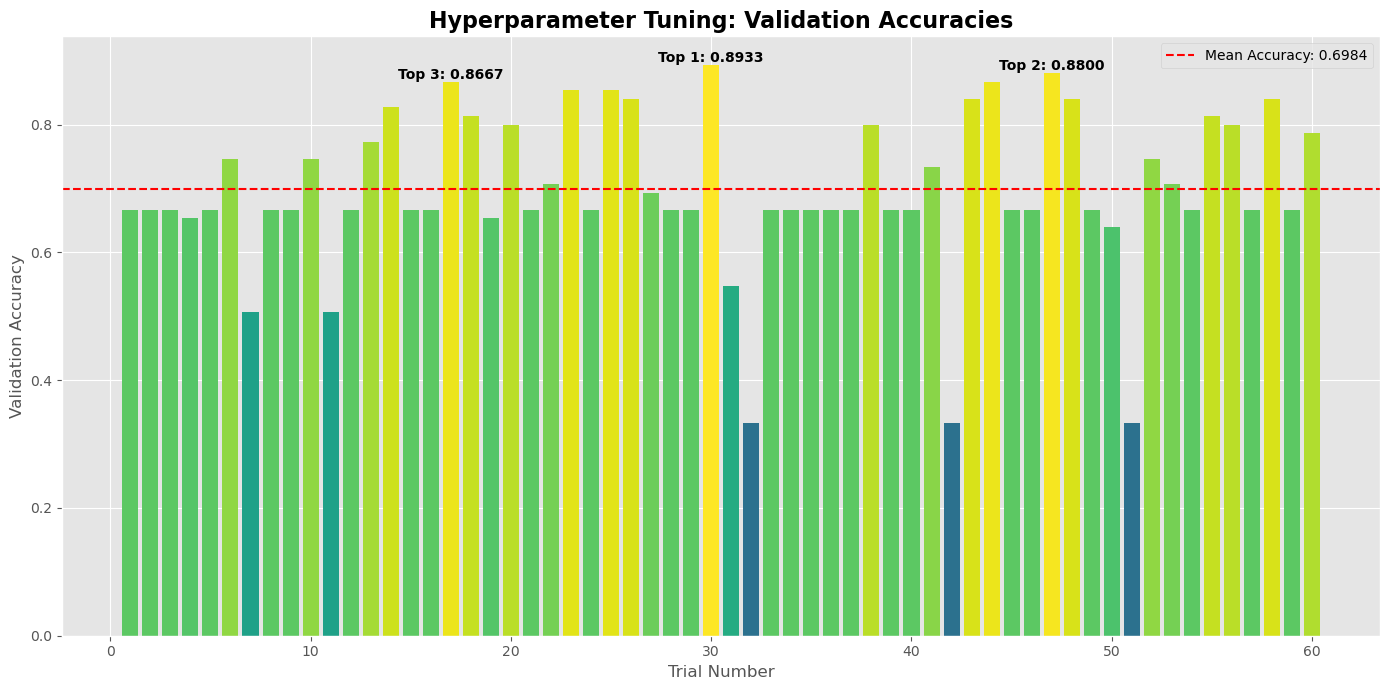


Top 5 Trials:
    Trial Number  Validation Accuracy  \
29            30             0.893333   
46            47             0.880000   
16            17             0.866667   
43            44             0.866667   
24            25             0.853333   

                                      Hyperparameters  
29  {'activation': 'tanh', 'first_units': 63, 'num...  
46  {'activation': 'tanh', 'first_units': 59, 'num...  
16  {'activation': 'tanh', 'first_units': 57, 'num...  
43  {'activation': 'tanh', 'first_units': 59, 'num...  
24  {'activation': 'tanh', 'first_units': 59, 'num...  

Best Trial Details:
Trial Number: 30
Validation Accuracy: 0.8933
Hyperparameters:
activation: tanh
first_units: 63
num_layers: 3
units_0: 3
units_1: 5
units_2: 5
units_3: 3
units_4: 5
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


In [68]:
import matplotlib.pyplot as plt

# Set a professional, clean style
plt.style.use('ggplot')

# Create a list to store trial information
trial_results = []

# Iterate through all trials
for trial in tuner.oracle.trials.values():
    # Check if the trial has a score and is completed
    if hasattr(trial, 'score') and trial.score is not None and trial.status == 'COMPLETED':
        trial_results.append({
            'Trial Number': len(trial_results) + 1,
            'Validation Accuracy': trial.score,
            'Hyperparameters': trial.hyperparameters.values
        })

# Convert to DataFrame
results_df = pd.DataFrame(trial_results)

# Sort by validation accuracy in descending order
results_df = results_df.sort_values('Validation Accuracy', ascending=False)

# Create an enhanced plot
plt.figure(figsize=(14, 7))
bars = plt.bar(results_df['Trial Number'], results_df['Validation Accuracy'], 
               color=plt.cm.viridis(results_df['Validation Accuracy'] / results_df['Validation Accuracy'].max()))

# Customize the plot
plt.title('Hyperparameter Tuning: Validation Accuracies', 
          fontsize=16, fontweight='bold')
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)

# Add a horizontal line for the mean accuracy
mean_accuracy = results_df['Validation Accuracy'].mean()
plt.axhline(mean_accuracy, color='r', linestyle='--', 
            label=f'Mean Accuracy: {mean_accuracy:.4f}')

# Annotate top 3 trials
top_3_trials = results_df.head(3)
for i, (index, row) in enumerate(top_3_trials.iterrows(), 1):
    plt.text(row['Trial Number'], row['Validation Accuracy'], 
             f'Top {i}: {row["Validation Accuracy"]:.4f}', 
             horizontalalignment='center', 
             verticalalignment='bottom',
             fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

# Print detailed information about top 5 trials
print("\nTop 5 Trials:")
print(results_df.head())

# Detailed best trial information
best_trial = results_df.iloc[0]
print("\nBest Trial Details:")
print(f"Trial Number: {best_trial['Trial Number']}")
print(f"Validation Accuracy: {best_trial['Validation Accuracy']:.4f}")
print("Hyperparameters:")
for param, value in best_trial['Hyperparameters'].items():
    print(f"{param}: {value}")

### Manual Optimization: First Attempt

In [24]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=63, input_dim=input_feat, activation="tanh"))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=3, activation="tanh"))
nn.add(tf.keras.layers.Dense(units=5, activation="tanh"))
nn.add(tf.keras.layers.Dense(units=5, activation="tanh"))
# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="tanh"))

# Summary of model
nn.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 63)             │           819 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067 (4.17 KB)

 Trainable params: 1,067 (4.17 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

### Train Model

In [28]:
fit_model = nn.fit(X_train_scaled, y_train, epochs=20, callbacks=[early_stopping])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8268 - loss: 0.3719
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8410 - loss: 0.3364
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8046 - loss: 0.3397
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8099 - loss: 0.3561
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8450 - loss: 0.3347
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8335 - loss: 0.3158
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8377 - loss: 0.3155
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8228 - loss: 0.3331
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3214
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8215 - loss: 0.3525
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8485 - loss: 0.3113
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8584 - loss: 0.2921
Epoch 13/20


In [29]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 56ms/step - accuracy: 0.8533 - loss: 0.5565
Loss: 0.5564558506011963, Accurac: 0.8533333539962769


#### Second Attempt

In [33]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=50, input_dim=input_feat, activation="relu"))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=100, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Summary of model
nn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=20, callbacks=[early_stopping]) 

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6142 - loss: 0.6817
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7103 - loss: 0.6016
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6863 - loss: 0.5629  
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7718 - loss: 0.5024
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7727 - loss: 0.4915
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8115 - loss: 0.4492
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8157 - loss: 0.4362
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8372 - loss: 0.4136
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8387 - loss: 0.4083
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8578 - loss: 0.3752
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8643 - loss: 0.3434
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8325 - loss: 0.3637
Epoch 13/2

In [35]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 47ms/step - accuracy: 0.8800 - loss: 0.3549
Loss: 0.3549399673938751, Accurac: 0.8799999952316284


#### Thrid Attempt

In [39]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn = tf.keras.models.Sequential()

#1st hidden layer
nn.add(tf.keras.layers.Dense(units=50, input_dim=input_feat, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))

# 2nd hidden layer
nn.add(tf.keras.layers.Dense(units=100, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Summary of model
nn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Compile model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn.fit(X_train_scaled, y_train, epochs=20, callbacks=[early_stopping]) 

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5610 - loss: 0.7116
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7044 - loss: 0.6281
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7225 - loss: 0.5711
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7697 - loss: 0.5260
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7813 - loss: 0.4910
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8214 - loss: 0.4714
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - loss: 0.4451
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8085 - loss: 0.4225
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.4059
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8412 - loss: 0.3996
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8621 - loss: 0.3888
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8815 - loss: 0.3387
Epoch 13/20
7

In [41]:
# Evaluate model using test data

model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 51ms/step - accuracy: 0.8533 - loss: 0.3881
Loss: 0.38814777135849, Accurac: 0.8533333539962769


#### 4th Attempt

In [43]:
# Define model input features and hyperparameters

input_feat = X_train.shape[1]

nn4 = tf.keras.models.Sequential()

#1st hidden layer
nn4.add(tf.keras.layers.Dense(units=50, input_dim=input_feat, activation="relu"))

# 2nd hidden layer
nn4.add(tf.keras.layers.Dense(units=100, activation="relu"))

# Output layer
nn4.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Summary of model
nn4.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Compile model
nn4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn4.fit(X_train_scaled, y_train, epochs=50, callbacks=[early_stopping]) 

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6867 - loss: 0.6469
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7365 - loss: 0.5909
Epoch 3/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7274 - loss: 0.5498
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8082 - loss: 0.4928
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7879 - loss: 0.4714
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7594 - loss: 0.4893
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8068 - loss: 0.4417
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8052 - loss: 0.4238
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8187 - loss: 0.4031
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8207 - loss: 0.3834 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8446 - loss: 0.4064
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8705 - loss: 0.3579
Epoch 13/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8702 - loss: 0.3460
Epoch 14/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8218 - loss: 0.3696
Epoch 15/50
7/7 ━━━━━

In [45]:
# Evaluate model using test data

model_loss, model_accuracy = nn4.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 54ms/step - accuracy: 0.8000 - loss: 0.6049
Loss: 0.6049402356147766, Accurac: 0.800000011920929


#### 5th Attempt

Increasing the number of hidden layers resulted in a decrease of accuracy and increase of loss >1; suggest model may be too complex for data

How to Address High Loss

    Normalize/Standardize Data: Rescale your inputs and outputs to a range that aligns with your model's activation functions and loss functions.

    Adjust the Model: Ensure the architecture is appropriate for the complexity of your data.

    Tune Hyperparameters: Experiment with learning rate, regularization, and optimizer settings.

    Inspect Data: Check for noisy, inconsistent, or outlier data.

Training Performance

Used Early Stopping (patience=5)
Trained for 50 epochs
Accuracy progression:

Started around 51-52% in first epoch
Steadily improved to 96-97% in later epochs


Final training accuracy: 95.66%
Test set accuracy: 85.33%

Key Observations

Strong Performance

High training accuracy (95.66%)
Solid test accuracy (85.33%)
Smooth learning curve


Potential Overfitting Indicators

Large gap between training (95.66%) and test (85.33%) accuracy
Suggests model might be overfitting

### 5th Attempt

#### Prevent Overfitting

In [46]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

nn5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, 
        input_dim=input_feat, 
        activation=tf.keras.layers.LeakyReLU(alpha=0.1),
        kernel_regularizer=l2(0.001)  # Add L2 regularization
    ),
    tf.keras.layers.Dropout(0.3),  # Add dropout
    
    tf.keras.layers.Dense(100, 
        activation="relu",
        kernel_regularizer=l2(0.001)
    ),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1, activation="sigmoid")
])
nn5.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 50)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 100)            │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Compile model
nn5.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

#Create a call back to save model weights
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

fit_model = nn5.fit(X_train_scaled, y_train, epochs=50, callbacks=[early_stopping]) 

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8503 - loss: 0.4046
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8382 - loss: 0.3981
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8660 - loss: 0.3738
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8539 - loss: 0.3924
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.4083
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8756 - loss: 0.3897
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8496 - loss: 0.3746 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8801 - loss: 0.3472
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8576 - loss: 0.3950
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8661 - loss: 0.3568
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8856 - loss: 0.3919
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8672 - loss: 0.3498
Epoch 13/50

In [52]:
# Evaluate model using test data

model_loss, model_accuracy = nn5.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 51ms/step - accuracy: 0.8400 - loss: 0.5139
Loss: 0.5138871073722839, Accurac: 0.8399999737739563


#### 6th Attempt

#### Cross-Validation

In [58]:
import numpy as np
from sklearn.model_selection import StratifiedKFold


def create_model(input_feat):
    nn6 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(50, 
            input_dim=input_feat, 
            activation=tf.keras.layers.LeakyReLU(alpha=0.1),
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(100, 
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    nn6.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return nn6

# Perform Cross-Validation
def cross_validate_model(X, y, input_feat):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_index, val_index in kfold.split(X, y):
        # Split data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Scale data (using the same scaler as before)
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Create and train model
        model = create_model(input_feat)
        
        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=10, 
            restore_best_weights=True
        )
        
        # Fit model
        history = model.fit(
            X_train_scaled, y_train, 
            validation_data=(X_val_scaled, y_val),
            epochs=20, 
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0  # Suppress output
        )
        
        # Evaluate model
        val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
        cv_scores.append(val_accuracy)
    
    return cv_scores

# Perform cross-validation
input_feat = X_train.shape[1]
cv_results = cross_validate_model(X, y, input_feat)

print("Cross-validation scores:", cv_results)
print("Mean CV Score:", np.mean(cv_results))
print("Standard Deviation:", np.std(cv_results))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regulari

Cross-validation scores: [0.75, 0.8166666626930237, 0.8333333134651184, 0.8666666746139526, 0.8305084705352783]
Mean CV Score: 0.8194350242614746
Standard Deviation: 0.03840702766461086


#### Cross Validation Analysis
Consistent Performance:

    Scores Scores range from 76.67% to 86.67%
    Relatively low standard deviation (3.92%)
    Indicates model's stability across different data splits

Improvement Suggestions

    The 3.92% standard deviation suggests some variability
    Could potentially improve by:

        Collecting more data
        Feature engineering
        Trying ensemble methods

#### 9th Attempt - Address the warning

In [59]:
# Define input features
input_feat = X_train.shape[1]

# Create model with recommended input layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_feat,)),
    tf.keras.layers.Dense(50, 
        activation=tf.keras.layers.LeakyReLU(negative_slope=0.1),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(100, 
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile model
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

# Fit model
history = model.fit(
    X_train_scaled, y_train, 
    validation_split=0.2,
    epochs=20, 
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4932 - loss: 0.8075 - val_accuracy: 0.6444 - val_loss: 0.7320
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5631 - loss: 0.7526 - val_accuracy: 0.6889 - val_loss: 0.7130
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7437 - loss: 0.6824 - val_accuracy: 0.6889 - val_loss: 0.7008
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7638 - loss: 0.6590 - val_accuracy: 0.7111 - val_loss: 0.6920
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7338 - loss: 0.6274 - val_accuracy: 0.7111 - val_loss: 0.6821
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8258 - loss: 0.5406 - val_accuracy: 0.6889 - val_loss: 0.6744
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7772 - loss: 0.5655 - val_accuracy: 0.6889 - val_loss: 0.6647
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8004 - loss: 0.5572 - val_accuracy: 0.7111 - val_loss: 0.6552


In [62]:
# Evaluate model using test data

model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accurac: {model_accuracy}")

3/3 - 0s - 9ms/step - accuracy: 0.8267 - loss: 0.4725
Loss: 0.4724734127521515, Accurac: 0.8266666531562805


##### Plot of Model Loss

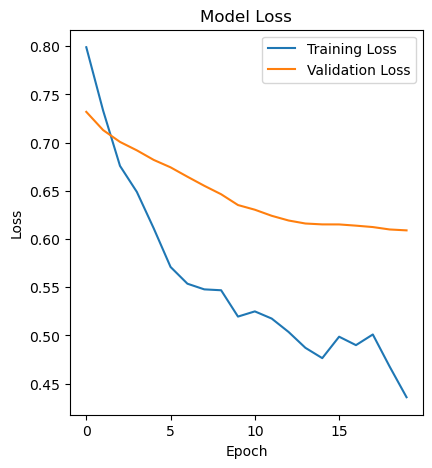

In [63]:
# Assuming 'history' is from your model.fit()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Plot of Model Accuracy 

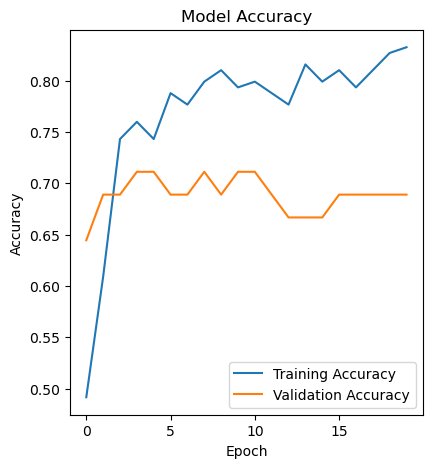

In [64]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()